# Beers in the USA: a prediction of State of origin based on beer tastes

## imports

In [5]:
from src.data.save_tar_gz import tar_gz_to_csv
from src.data.load_data import load_data_from_csv
from src.utils.data_utils import *
from src.data.additional_data import *
import warnings
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import src.data.wrangling as wrangling

## Loading the data into dict. of dataframes

This part loads the data from the specified path. There are two options. The first one is to load directly from the compressed .tar.gz files, which is needed for the first run and that will save the data files in readable .csv files. Once we have these .csv files, we can directly load from them using the second option.


### Option 1: data still in .tar.gz

In [ ]:
# Use these lines for the first loading, tar.gz files must be in the data/ folder. After executing them, directly do the wrangling to save clean .csv
warnings.filterwarnings("ignore")
data = tar_gz_to_csv(load_path= 'data/', save_path='data/raw/', load_text = False)
warnings.filterwarnings("default")

### Option 2: data in .csv

In [ ]:
# Use this line if you have all the data extracted to wrangled csv files under data/raw in subfolders BeerAdvocate, RateBeer, and MatchedBeerData.
# It loads the data into 3 dictionnaries containing the dataframes
data_ba, data_rb, data_matched = load_data_from_csv('data/raw/')

In [ ]:
print(data_ba.keys())
print(data_rb.keys())
print(data_matched.keys())

#remove textual review columns if needed
remove_txt_columns(data_ba, data_rb, data_matched)

In [ ]:
data_ba['BeerAdvocate_ratings.csv'].head()

# Cleaning and wrangling the data

For each dataset, we will clean the data by removing duplicates, missing values, and irrelevant columns.
To remove missing values we'll use the following strategy:
We'll extract a new column containing a boolean value indicating if the row has missing values. And replace the missing values by 0. This can be useful in a logistic regression if having a missing value at field x actually yields some information.

N.B.: since the datasets are quite heavy, we overwrite the raw files with the wrangled ones instead of saving new files. If we want the raw files again, we have to load again the tar_gz_to_csv function as explained above.

In [1]:
data_path = "data/raw"
Ratebeer_path = lambda path: f"{data_path}/Ratebeer"
BeerAdvocate_path = lambda path: f"{data_path}/BeerAdvocate"
Matched_path = lambda path: f"{data_path}/MatchedBeerData"
clean_path = "data/clean"

### Cleaning BeerAdvocate data

We'll start by cleaning the BeerAdvocate data. We'll clean the users, ratings, beers, and breweries data.
For users, we'll only focus on american users. 
We'll filter the users by their location and keep only the ones that have a location in the USA. Same with ratings we'll remove those not made by american users. We also remove the text reviews as we won't use them. Finally the missing data are handled as explained above.

In [ ]:
wrangling.clean_beer_advocate(
    raw_data_path=BeerAdvocate_path(data_path),
    clean_data_path=BeerAdvocate_path(clean_path)
)

### Cleaning RateBeer data

The cleaning process is exactly the same as for BeerAdvocate

In [6]:
wrangling.clean_ratebeer(
    raw_data_path=Ratebeer_path(data_path),
    clean_data_path=Ratebeer_path(clean_path)
)

### Cleaning Matched data

Here the cleaning is a bit different as we have to match the data from BeerAdvocate and RateBeer.
As the columns have multiple types (the first row contains the name of the column in the original dataset), we have to clean them first. We'll delete the first row and append it to the column names so that they are more readable (for example ra_1 becomes ra_text). We'll then convert the columns to the correct type and remove the rows with missing values. The rest of the cleaning process is the same as for the other datasets.

In [7]:
wrangling.clean_matched_data(
    raw_data_path=Matched_path(data_path),
    clean_data_path=Matched_path(clean_path)
)

## Analyse distribution of US users per state

This part displays the distribution of users per US state. There are more than 130'000 users in America, not evenly distributed. The state with the most users has more than 14'000 of them, whereas the states with the least amount of users have only a couple hundreds of them. These numbers are reasonnably well correlated with the population in each state.

In [ ]:
# get the data

users_matched = data_matched['matched_beer_data_users.csv']
users_ba = data_ba['BeerAdvocate_users.csv']
users_rb = data_rb['RateBeer_users.csv']
users_ba = users_ba.dropna(subset=['location'])
users_rb = users_rb.dropna(subset=['location'])

In [ ]:
# get the number of American users

users_matched_usa = users_matched[users_matched['ba.1'].str.startswith('United States')]
users_ba_usa = users_ba[users_ba['location'].str.startswith('United States')]
users_rb_usa = users_rb[users_rb['location'].str.startswith('United States')]

print(f"Number of matched users in USA: {users_matched_usa.shape[0]}")
print(f"Number of BeerAdvocate users in USA: {users_ba_usa.shape[0]}")
print(f"Number of RateBeer users in USA: {users_rb_usa.shape[0]}")

In [ ]:
# compute the statewise distribution of users

states_usa_ba = users_ba_usa['location'].apply(lambda x: x.split(', ')[1])
states_usa_rb = users_rb_usa['location'].apply(lambda x: x.split(', ')[1])

# print(f"USA states represented in BeerAdvocate: {len(states_usa_ba.unique())}")
# print(f"USA states represented in RateBeer: {len(states_usa_rb.unique())}")

# print(f"Number of users per state in BeerAdvocate: {states_usa_ba.value_counts()}")
# print(f"Number of users per state in RateBeer: {states_usa_rb.value_counts()}")

users_per_state_ba = states_usa_ba.value_counts().to_dict()
users_per_state_rb = states_usa_rb.value_counts().to_dict()
users_per_state_barb = {k: (users_per_state_ba[k] + users_per_state_rb[k]) for k in users_per_state_ba.keys()}

states = users_per_state_barb.keys()
users = users_per_state_barb.values()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, users)
ax.set_ylabel('Number of users')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()

## Analyse distribution of US Breweries per state

This part displays the distribution of breweries per US state. There are more than 10'000 breweries in America, not evenly distributed. The state with the most breweries has about 1'800 of them, whereas the states with the least amount of users have a couple tens of them. These numbers are reasonnably well correlated with the population in each state.

In [ ]:
# get the data

breweries_matched = data_matched['matched_beer_data_breweries.csv']
breweries_ba = data_ba['BeerAdvocate_breweries.csv']
breweries_rb = data_rb['RateBeer_breweries.csv']
breweries_ba = breweries_ba.dropna(subset=['location'])
breweries_rb = breweries_rb.dropna(subset=['location'])

In [ ]:
# get the number of American breweries

breweries_matched_usa = breweries_matched[breweries_matched['ba.1'].str.startswith('United States')]
breweries_ba_usa = breweries_ba[breweries_ba['location'].str.startswith('United States')]
breweries_rb_usa = breweries_rb[breweries_rb['location'].str.startswith('United States')]

print(f"Number of matched breweries in USA: {breweries_matched_usa.shape[0]}")
print(f"Number of BeerAdvocate breweries in USA: {breweries_ba_usa.shape[0]}")
print(f"Number of RateBeer breweries in USA: {breweries_rb_usa.shape[0]}")

In [ ]:
# compute the statewise distribution of breweries

breweries_name_split_ba = breweries_ba_usa['location'].apply(lambda x: len(x.split(',')))
breweries_filtered_ba = breweries_ba_usa[breweries_name_split_ba == 2]
breweries_filtered_ba = breweries_filtered_ba[breweries_filtered_ba['location'] != 'United States, United States']
breweries_per_states_ba = breweries_filtered_ba['location'].apply(lambda x: x.split(',')[1])

breweries_name_split_rb = breweries_rb_usa['location'].apply(lambda x: len(x.split(',')))
breweries_filtered_rb = breweries_rb_usa[breweries_name_split_rb == 2]
breweries_filtered_rb['location'] = breweries_filtered_rb['location'].mask(breweries_filtered_rb['location'] == 'United States, Washington DC', 'United States, California')
breweries_per_states_rb = breweries_filtered_rb['location'].apply(lambda x: x.split(',')[1])

# print(f"USA states with breweries represented in BeerAdvocate: {len(breweries_per_states_ba.unique())}")
# print(f"USA states with breweries represented in RateBeer: {len(breweries_per_states_rb.unique())}")

# print(f"Number of breweries per state in BeerAdvocate: {breweries_per_states_ba.value_counts()}")
# print(f"Number of breweries per state in RateBeer: {breweries_per_states_rb.value_counts()}")

breweries_per_state_ba = breweries_per_states_ba.value_counts().to_dict()
breweries_per_state_rb = breweries_per_states_rb.value_counts().to_dict()

# delete the space at the start of each key
breweries_per_state_ba = {k[1:]: v for k, v in breweries_per_state_ba.items()}
breweries_per_state_rb = {k[1:]: v for k, v in breweries_per_state_rb.items()}

breweries_per_state_barb = {k: (breweries_per_state_ba[k] + breweries_per_state_rb[k]) for k in breweries_per_state_ba.keys()}

states = breweries_per_state_barb.keys()
users = breweries_per_state_barb.values()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, users)
ax.set_ylabel('Number of users')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()

## Analyse ratio of users per brewery in each state

This part displays the ratio of users per brewery in each American state. Compared to the two previously computed distribution, the ranking is less strongly correlated with the population of each states.

In [ ]:
# Amount of users per brewery in each state
users_per_brewery_barb = {k: (users_per_state_barb[k] / breweries_per_state_barb[k]) for k in users_per_state_ba.keys()}
print(users_per_brewery_barb)

# Sort so easier to view plot
sorted_users_per_brewery_ba = dict(sorted(users_per_brewery_barb.items(), key=lambda item: item[1]))

states = sorted_users_per_brewery_ba.keys()
users_per_brewery = sorted_users_per_brewery_ba.values()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, users_per_brewery)
ax.set_ylabel('Number of users per brewery')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()

### Data from Census

Print the data from the urban vs rural census. As mentioned in the README, this data will probably not be used in the final rapport.

In [ ]:
census_path = 'data/raw/Census/'
file_name_2020 = 'DECENNIALCD1182020.H2_rural_urban_US.csv'
file_name_2010 = 'DECENNIALCD1162010.H2_rural_urban_US.csv'

urban_2020_df = load_urban_frac_df(census_path, file_name_2020).reset_index()
urban_2010_df = load_urban_frac_df(census_path, file_name_2010).reset_index()

print(urban_2020_df.head())
print(urban_2010_df.head())

## Data from BEA

This dataframe contains various statewise economic indicators, more info in the source or in the index of the .csv. The following dictionnary gives a first overview.

In [ ]:
path = "data/raw/IncomeBEA/"
filename = "GDP_PersonalIncome_USState.csv"

# DPI: disposable personal income
# PI: personal income
# PCE: personal consumption expenditures
# GDP: Gross Domestic Product
BEO_income_index = {
    'RealGDP': 1, 
    'RealPI':2, 
    'RealPCE': 3,
    'GDP': 4,  
    'PI': 5, 
    'DPI': 6,
    'PCE': 7,
    'RealPI/cap': 8,
    'RealPCE/cap': 9,
    'PI/cap': 10,
    'DPI/cap': 11,
    'PCE/cap': 12     
    #13 14 15 useless
}

As an example of possible plot, below is the statewise Real Personal consumption expenditure per capita for the year 2010.

In [ ]:

BEA = loadBEA(path, filename, BEO_income_index)
BEA = get_mutliIndex_sub_df(BEA, ['RealPCE/cap'], ['2010'])

states = [x[0] for x in BEA.index.values]

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, BEA['RealPCE/cap'])
ax.set_ylabel('Real Personal Consumption expenditures per capita')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()

## Number of users per habitant in each state
This allows us to see if we have enough users per state, compared to its population. These values range approximately between 500 and 3'000 inhabitant per user.

In [ ]:
# get the statewise population by adding the rural and urban population

if all(col in urban_2010_df.columns for col in ['urban_pop', 'rural_pop', 'urban_frac']):
    urban_2010_df = urban_2010_df.drop(columns=['urban_pop', 'rural_pop', 'urban_frac'])
urban_2010_dict = urban_2010_df.set_index('state').to_dict()['total_pop']

# delete keys states that are not in the 50 official
urban_2010_dict = {k: v for k, v in urban_2010_dict.items() if k in users_per_state_barb.keys()}

# number of habitants per user in each state
users_per_habitant = {k: (urban_2010_dict[k] / users_per_state_barb[k]) for k in users_per_state_barb.keys()}
print(users_per_habitant)

states = users_per_habitant.keys()
users_per_habitant = users_per_habitant.values()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, users_per_habitant)
ax.set_ylabel('Number of users per habitant')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()

## Alcohol consumption per capita per state

This loads the statewise alcohol data table and displays the two most interesting column to us, the per capita beer ethanol consumption and per capita nominal beer consumption.

In [ ]:
icpsr_path = 'data/raw/OPENICPSR/OPENICPSR_apparent_per_capita_alcohol_consumption.csv'
data_icpsr = load_icpsr(icpsr_path) # load + format data
print('available years: ', data_icpsr.keys())
data_icpsr['2016'].head(5)

## Age distribution per state

This loads the statewise age distribution. They are expressed in two ways per 5 years age interval, in absolute count and in relative percentage.

In [ ]:
age_path = 'data/raw/GeneralPopulationAge/DECENNIALDP2020.DP1-2024-11-14T134434.csv'
age_total, age_male, age_female = load_age_data(age_path, load_gender = True)
age_total.head(5)

In [22]:
def get_ba_beer_merged():
    ba_usa_ratings = pd.read_csv("data/clean/BeerAdvocate/usa_ratings.csv")
    ba_usa_users = pd.read_csv("data/clean/BeerAdvocate/usa_users.csv")

    ba_usa_ratings = ba_usa_ratings.merge(ba_usa_users[['user_id', 'location']], on='user_id', how='left')
    ba_usa_ratings['state'] = ba_usa_ratings['location'].apply(lambda x: x.split(', ')[-1])

    return ba_usa_ratings


ba_usa_ratings = get_ba_beer_merged()

In [76]:
#users_matched = data_matched['matched_beer_data_users.csv']
#users_ba = data_ba['BeerAdvocate_users.csv']
#users_rb = data_rb['RateBeer_users.csv']

# need to add column of beer rating
#ba_beers = pd.read_csv(f"{BeerAdvocate_path(clean_path)}/beers.csv")

# grouped by beer and state
column_to_group = 'style'

#ba_usa_ratings['state'] = ba_usa_ratings['location'].apply(lambda x: x.split(', ')[-1])
reviews_by_beer_state = ba_usa_ratings.groupby(['state', column_to_group]).mean(numeric_only=True).reset_index()
#reviews_by_state = ba_usa_ratings['abv', 'location'].groupby('location').mean()#.reset_index(name='review_count')
reviews_by_beer_state = reviews_by_beer_state.loc[:, ['state', column_to_group, 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']]
# to know how many got grouped
reviews_by_beer_state['review_count'] = ba_usa_ratings.groupby(['state', column_to_group]).size().values
reviews_by_beer_state = reviews_by_beer_state.loc[reviews_by_beer_state["review_count"] > 10]    # only more than 10 reviews by beer

# selected_rows = reviews_by_beer_state[reviews_by_beer_state['style'] == "English Pale Ale"]

beer_styles = pd.unique(reviews_by_beer_state[column_to_group])
print(len(beer_styles))
# selected_rows



104


## Top-Rated Beer Styles

In [77]:
#top-rated beer styles overall
top_beer_styles = reviews_by_beer_state.groupby('style')['overall'].mean().sort_values(ascending=False)
print("Top-rated beer styles across the U.S.:")
print(top_beer_styles.head(10))

#top-rated beer style per state
top_beer_styles_by_state = reviews_by_beer_state.loc[reviews_by_beer_state.groupby('state')['overall'].idxmax()]
print("Top-rated beer styles by state:")
print(top_beer_styles_by_state[['state', 'style', 'overall']])


Top-rated beer styles across the U.S.:
style
Gose                                2.974140
Kvass                               2.867680
Eisbock                             2.702948
Berliner Weissbier                  2.642580
American Wild Ale                   2.590513
English Pale Mild Ale               2.578963
American Double / Imperial Stout    2.568663
Baltic Porter                       2.564610
Weizenbock                          2.561228
Roggenbier                          2.546682
Name: overall, dtype: float64
Top-rated beer styles by state:
               state                      style   overall
8            Alabama    American Dark Wheat Ale  2.819444
148           Alaska      English Dark Mild Ale  4.154762
239          Arizona                    Braggot  3.444444
352         Arkansas                    Eisbock  3.521739
475       California                       Gose  2.750821
558         Colorado                    Eisbock  3.062925
683      Connecticut                 

## Diversity in Preferences

Beer styles with the highest variance in ratings across states:
style
Happoshu                 0.422093
Braggot                  0.289281
Roggenbier               0.282390
English Dark Mild Ale    0.266829
Gueuze                   0.265421
Kristalweizen            0.257993
Bière de Garde           0.241892
Kvass                    0.221174
Eisbock                  0.208452
English Strong Ale       0.203835
Name: overall, dtype: float64


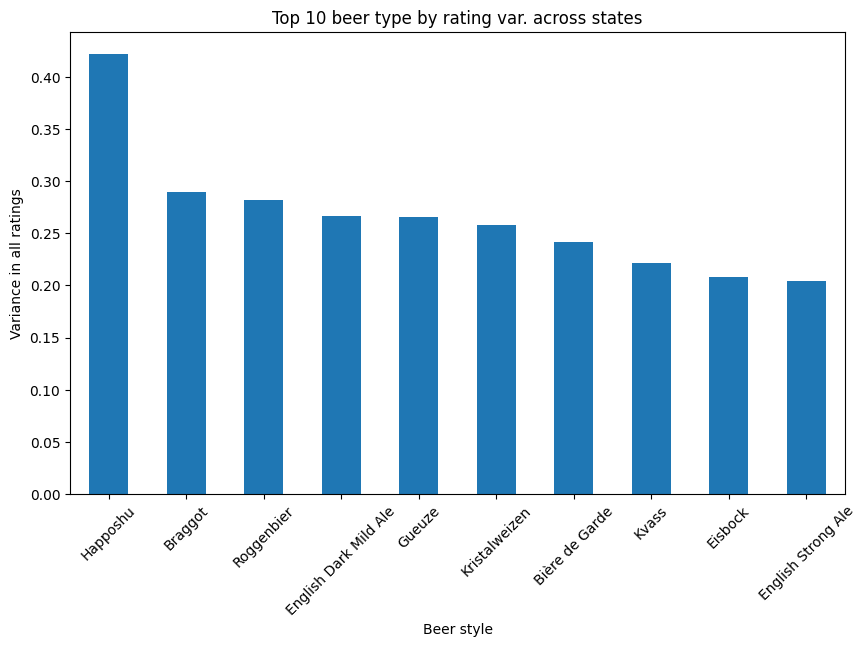

In [84]:
#variance in ratings for each beer style across all states
rating_variance_by_style = reviews_by_beer_state.groupby('style')['overall'].var().sort_values(ascending=False)
print("Beer styles with the highest variance in ratings across states:")
print(rating_variance_by_style.head(10))

# plot top10 by highest var.
plt.figure(figsize=(10, 6))
rating_variance_by_style.head(10).plot(kind='bar')
plt.title('Top 10 beer type by rating var. across states')
plt.xlabel('Beer style')
plt.ylabel('Variance in all ratings')
plt.xticks(rotation=45)
plt.show()


## Correlation of data for global rating

Correlation of criterion with rating by beer style
                                 appearance     aroma    palate     taste  \
Altbier                           -0.078269 -0.063418 -0.045403 -0.032804   
American Adjunct Lager             0.288332  0.317479  0.322582  0.344913   
American Amber / Red Ale           0.062904  0.106254  0.097755  0.104936   
American Amber / Red Lager         0.150192  0.155615  0.151391  0.151476   
American Barleywine               -0.044680 -0.032289 -0.039025 -0.026704   
...                                     ...       ...       ...       ...   
Braggot                            0.113204  0.133813  0.122774  0.158288   
Faro                               0.097795  0.186831  0.156079  0.196818   
Lambic - Unblended                 0.186612  0.153148  0.157018  0.182692   
Bière de Champagne / Bière Brut    0.332704  0.378910  0.391410  0.403145   
Roggenbier                         0.056153  0.077936  0.027464  0.069238   

                        

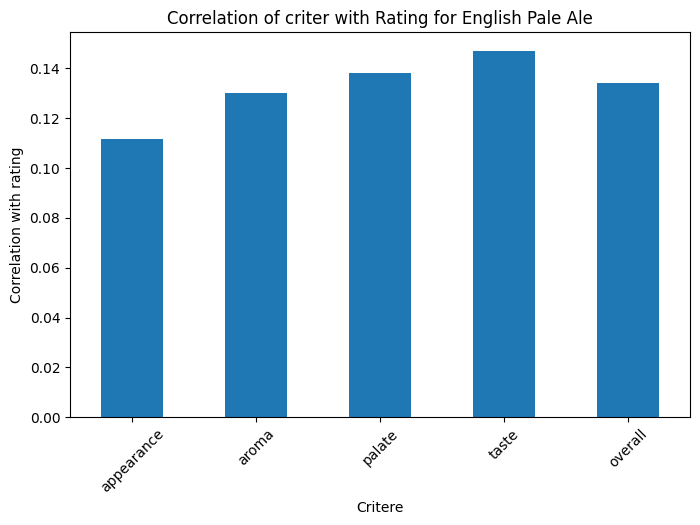

In [85]:
#criterias to analyse corr. with rating
criteria = ['appearance', 'aroma', 'palate', 'taste', 'overall']
criteria_correlation_by_style = {}

for style in beer_styles:
    style_data = reviews_by_beer_state[reviews_by_beer_state['style'] == style]
    if len(style_data) > 20:
        correlations = style_data[criteria + ['rating']].corr()['rating'].drop('rating')
        criteria_correlation_by_style[style] = correlations

criteria_correlation_df = pd.DataFrame(criteria_correlation_by_style)
criteria_correlation_df = criteria_correlation_df.T

print("Correlation of criterion with rating by beer style")
print(criteria_correlation_df)

specific_style = "English Pale Ale"
if specific_style in criteria_correlation_df.index:
    criteria_correlation_df.loc[specific_style].plot(kind='bar', figsize=(8, 5))
    plt.title(f'Correlation of criter with Rating for {specific_style}')
    plt.xlabel('Critere')
    plt.ylabel('Correlation with rating')
    plt.xticks(rotation=45)
    plt.show()

